In [238]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Local Paths (NB Inputs)

In [5]:
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas_abell370_f105w_v1.0-epoch2_drz.fits"
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz.fits"
#input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_acs-30mas-selfcal_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
#input_data_path = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [6]:
hdul = fits.open(input_data_path)
hdu = hdul[0]

In [7]:
data = hdu.data
header = hdu.header
wcs = WCS(header)

In [8]:
#plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

# Estimate Mean Noise

0.000312165

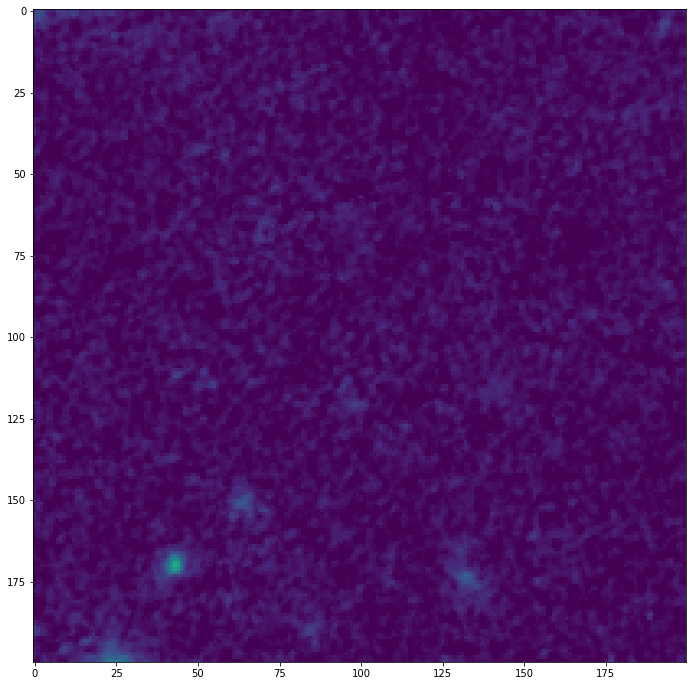

In [9]:
subsection = cutout(data, 4444, 10150, 200)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

In [10]:
mean_noise = subsection.mean()
mean_noise

0.000312165

# Aperture Photometry

### Select Image

In [459]:
cx, cy = wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])
#image = cutout(data, int(cx), int(cy), 6000)
image = cutout(data, int(cx), int(cy), 4000)

#image = cutout(data,3595, 6377,  1000)
#image = cutout(data, 2072, 8309, 1000)
#image = cutout(data, 3791, 7332, 2000)
#image = data[1000:-1000,1000:-1000]

image -= mean_noise
#mean_noise = image.mean()

In [460]:
image = np.clip(image, 0, image.max())

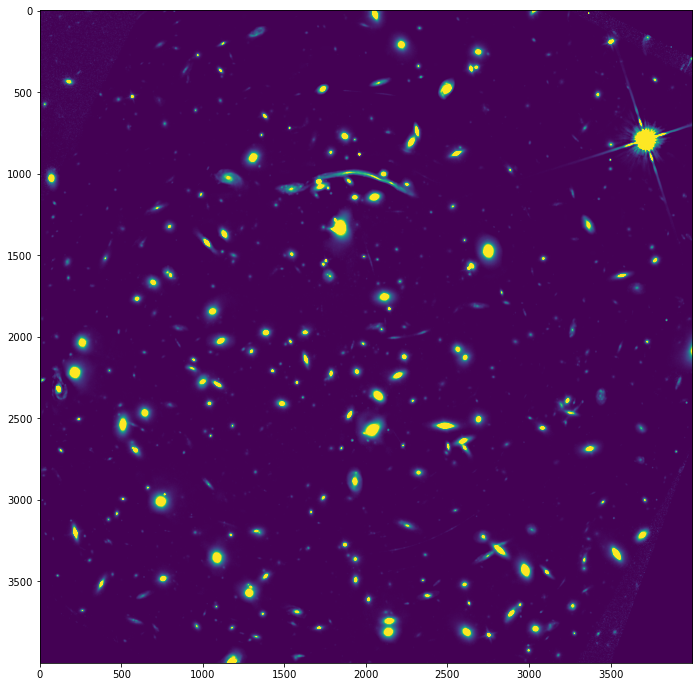

In [183]:
plt.imshow(image, vmin=0, vmax=mean_noise*300)

### Make Segments

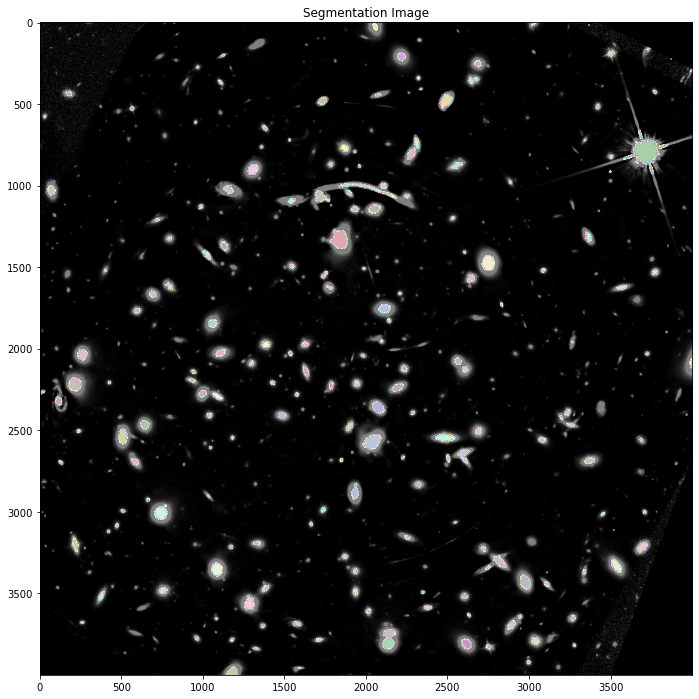

In [210]:
nsigma = np.zeros_like(image) + image.mean()*5
segm = make_segments(image, nsigma=nsigma, kernel_size=None)
plot_segments(segm, image, vmin=0, vmax=mean_noise*50)

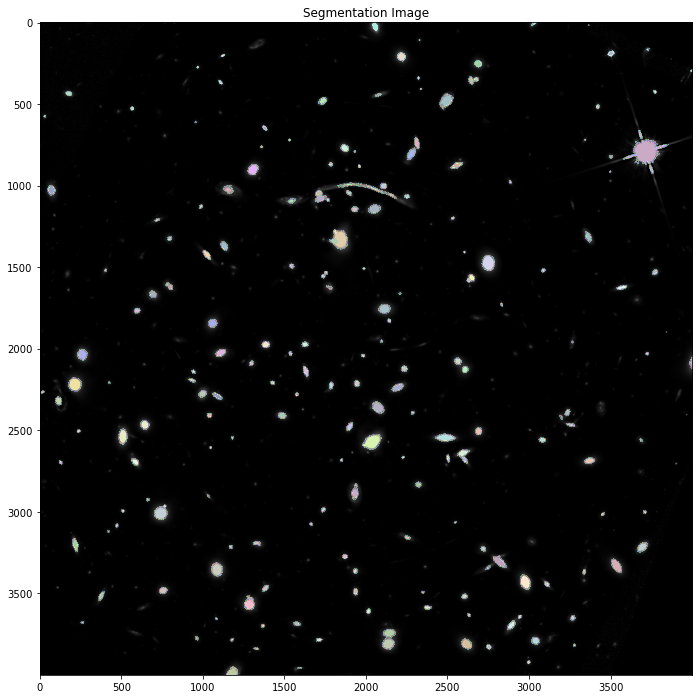

In [211]:
segm_deblend = deblend_segments(image, segm)
plot_segments(segm_deblend, image, vmin=0, vmax=mean_noise*300)

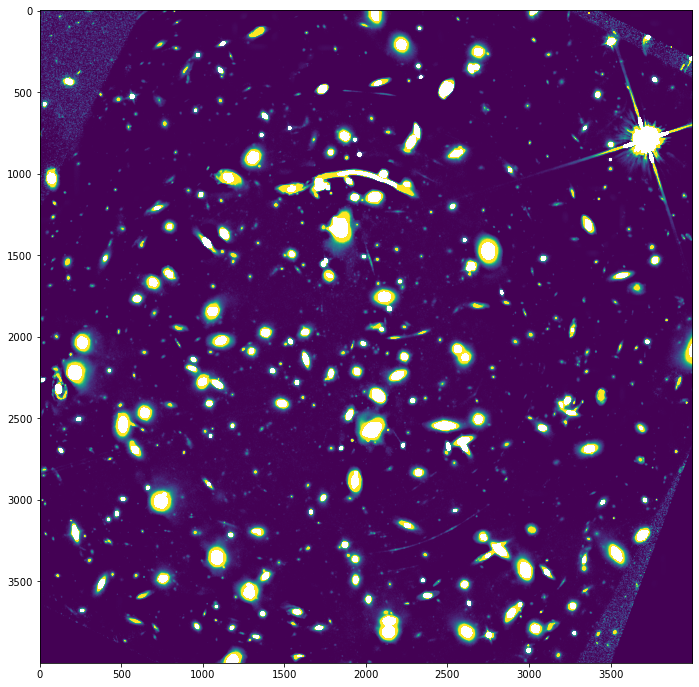

In [212]:
image_residual = image.copy()
image_residual[np.where(segm.data != 0)] = np.nan
plt.imshow(image_residual, vmin=0, vmax=mean_noise*50)
#plot_segment_residual(segm_deblend, image)

In [213]:
segm_deblend.remove_border_labels(50)
len(segm_deblend.segments)

198

### Make Catalog

In [214]:
cat = source_properties(image, segm_deblend, wcs=wcs)

# Fitted Photometry

In [215]:
table = cat.to_table()['area']
order_all = table.argsort()
order_all = list(reversed(order_all))
len(order_all)

198

In [216]:
order = order_all[1:15]

IntProgress(value=0, description='Loading:', max=14)

0 107


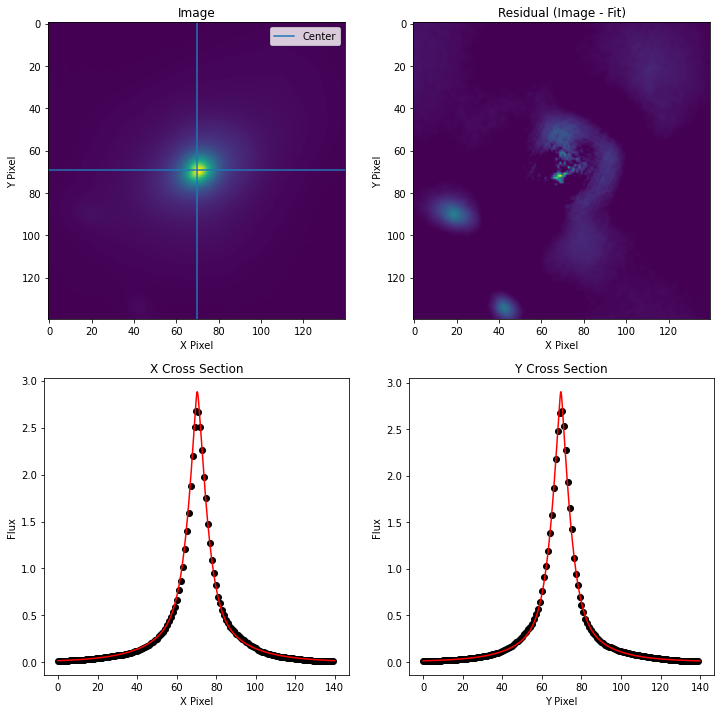

('amplitude_0', 0.5128776323046442)
('r_eff_0', 6.375191717362362)
('n_0', 0.7013671250117743)
('x_0_0', 70.52492502070773)
('y_0_0', 69.47490239087406)
('ellip_0', 0.0)
('theta_0', 0.0)
('amplitude_1', 0.14907126946400304)
('r_eff_1', 33.90970885391368)
('n_1', 1.3501747746548352)
('x_0_1', 70.52492502070773)
('y_0_1', 69.47490239087406)
('ellip_1', 0.3112538871323397)
('theta_1', -0.5830250822706463)



1 181


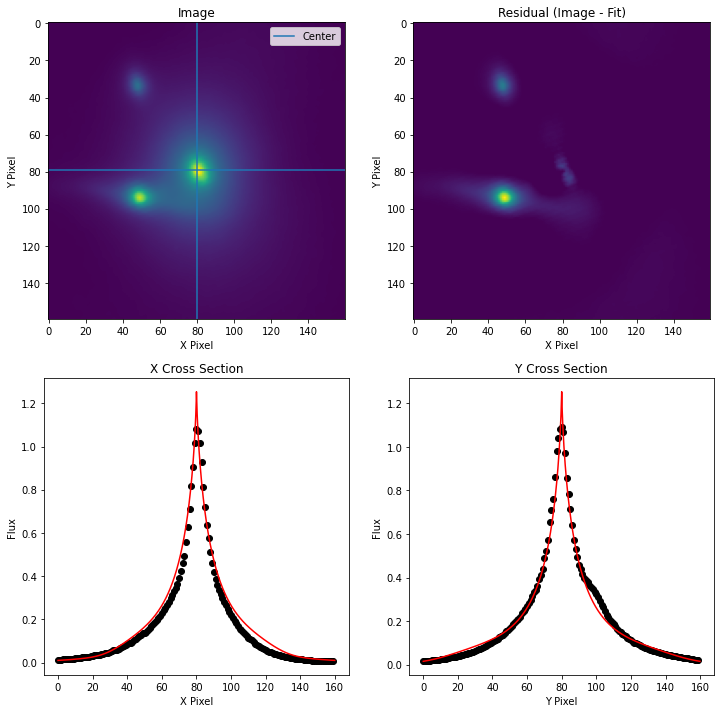

('amplitude_0', 0.10536944593631764)
('r_eff_0', 34.717137305960705)
('n_0', 1.3832751381309867)
('x_0_0', 80.01364808504009)
('y_0_0', 79.98344421116846)
('ellip_0', 0.1789097409884022)
('theta_0', 2.401552125962801)
('amplitude_1', 0.04976570602082209)
('r_eff_1', 46.268842575883)
('n_1', 0.19745277696508035)
('x_0_1', 80.01364808504009)
('y_0_1', 79.98344421116846)
('ellip_1', 0.32736831075963835)
('theta_1', 1.4646553611169357)



2 51


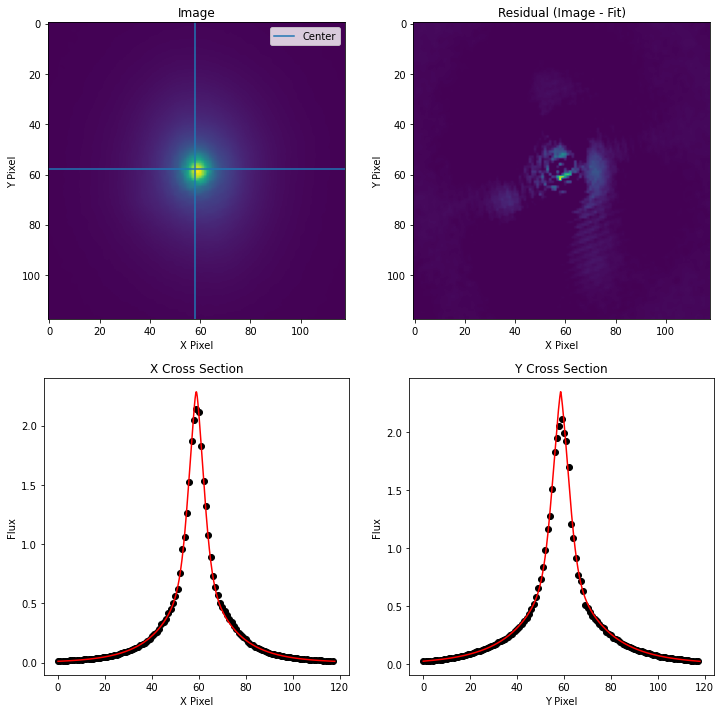

('amplitude_0', 0.49192586459464877)
('r_eff_0', 4.350558810248779)
('n_0', 0.5443861871521464)
('x_0_0', 58.89782814861955)
('y_0_0', 58.54586109726051)
('ellip_0', 0.08208858591191627)
('theta_0', 1.6026403667522553)
('amplitude_1', 0.17749311648468774)
('r_eff_1', 27.519342605487527)
('n_1', 1.156983999176844)
('x_0_1', 58.89782814861955)
('y_0_1', 58.54586109726051)
('ellip_1', 0.20218895850436325)
('theta_1', 1.4965970511236515)



3 83


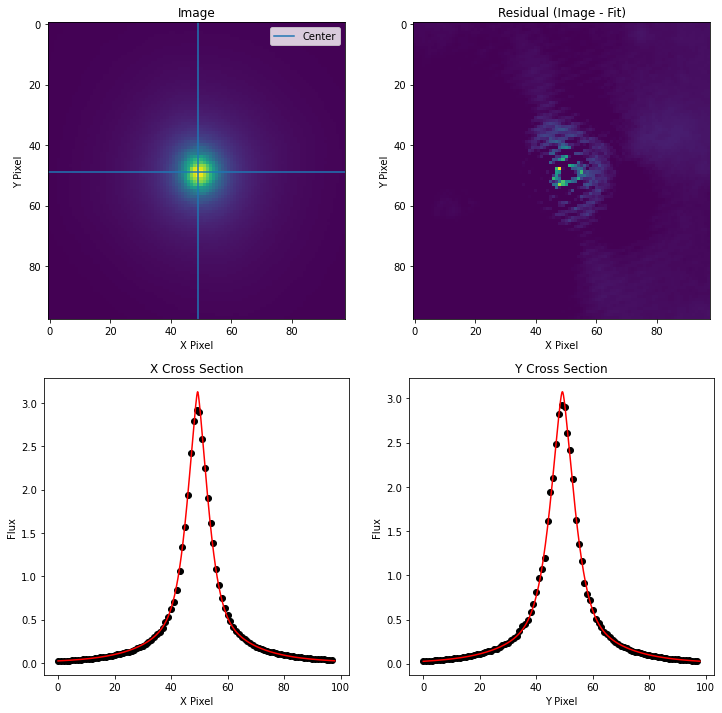

('amplitude_0', 0.7149317656753118)
('r_eff_0', 5.7190205664834)
('n_0', 0.643900246584419)
('x_0_0', 49.40243589249134)
('y_0_0', 49.23472569740179)
('ellip_0', 0.1327748180109671)
('theta_0', 1.496374238326593)
('amplitude_1', 0.1778307896716181)
('r_eff_1', 22.99241543671979)
('n_1', 1.1556463682615925)
('x_0_1', 49.40243589249134)
('y_0_1', 49.23472569740179)
('ellip_1', 0.06544471082786152)
('theta_1', 1.3654399064402003)



4 194


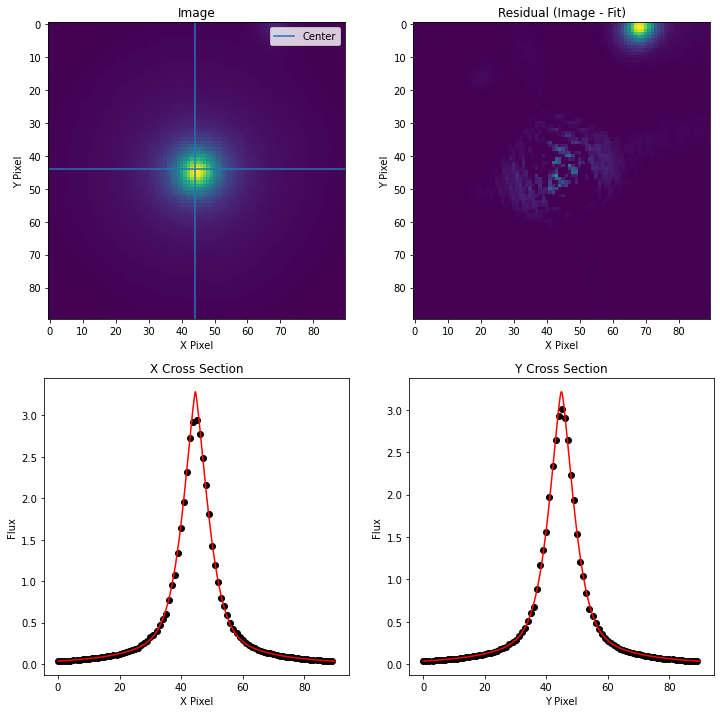

('amplitude_0', 0.8327994683135301)
('r_eff_0', 5.950951613217386)
('n_0', 0.68606934981088)
('x_0_0', 44.625450717551594)
('y_0_0', 44.89116455283893)
('ellip_0', 0.014759727103937748)
('theta_0', 0.0)
('amplitude_1', 0.10865761005015145)
('r_eff_1', 27.013921577847952)
('n_1', 1.230210371166415)
('x_0_1', 44.625450717551594)
('y_0_1', 44.89116455283893)
('ellip_1', 0.005088917119073888)
('theta_1', 0.4675264549155568)



5 172


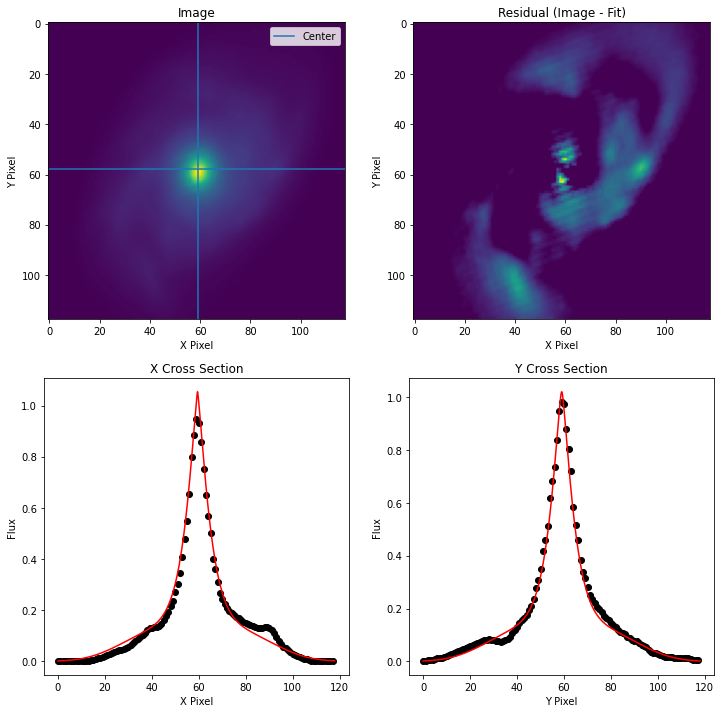

('amplitude_0', 0.2467285906225366)
('r_eff_0', 7.6788597752637955)
('n_0', 0.8159300820168603)
('x_0_0', 59.44187188654257)
('y_0_0', 58.991038499746644)
('ellip_0', 0.0)
('theta_0', 6.283185307179586)
('amplitude_1', 0.09646655891482331)
('r_eff_1', 30.864081895570006)
('n_1', 0.3260884898919823)
('x_0_1', 59.44187188654257)
('y_0_1', 58.991038499746644)
('ellip_1', 0.2506663779805334)
('theta_1', -0.7921768933641777)



6 137


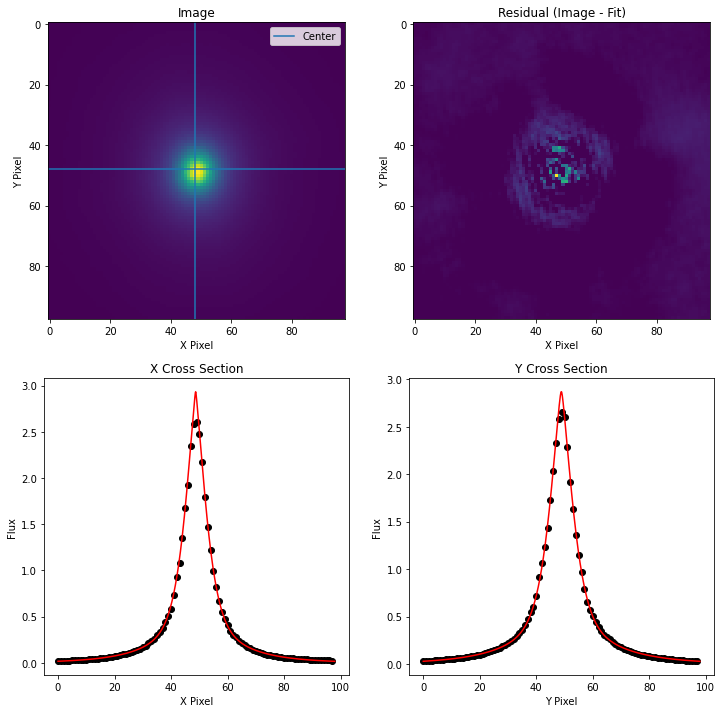

('amplitude_0', 0.6320721183983434)
('r_eff_0', 5.9020365129144725)
('n_0', 0.6892894987235365)
('x_0_0', 48.68356122195464)
('y_0_0', 48.84674188859247)
('ellip_0', 0.08890358928536508)
('theta_0', 1.7992757719512849)
('amplitude_1', 0.13402182373191596)
('r_eff_1', 25.258179006449264)
('n_1', 1.237846777541729)
('x_0_1', 48.68356122195464)
('y_0_1', 48.84674188859247)
('ellip_1', 0.15734398509279424)
('theta_1', 1.4557277760795713)



7 141


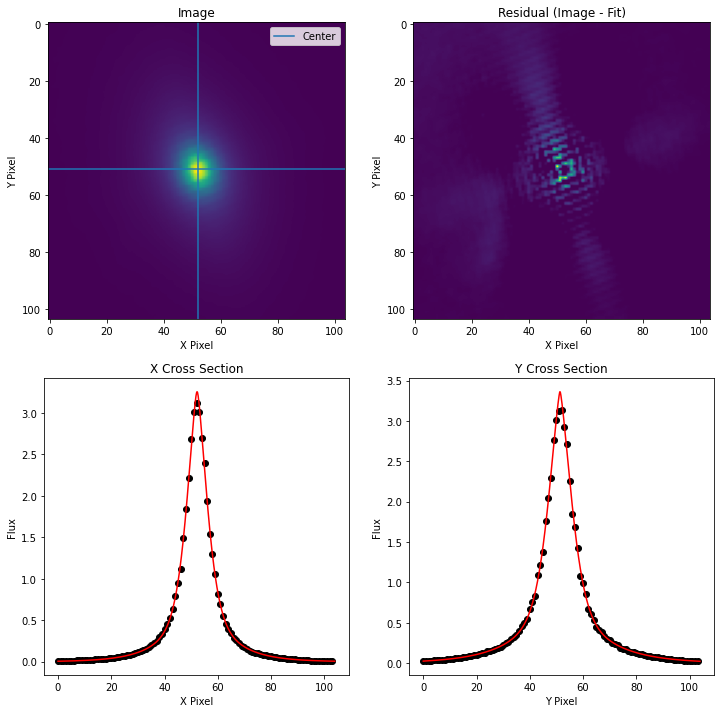

('amplitude_0', 0.8017516450246346)
('r_eff_0', 6.115688412161048)
('n_0', 0.645666838172214)
('x_0_0', 52.12848589522128)
('y_0_0', 51.377047586901135)
('ellip_0', 0.1622211718642588)
('theta_0', 1.2980071297300382)
('amplitude_1', 0.20034806943700992)
('r_eff_1', 24.435204850090567)
('n_1', 1.0818655662651948)
('x_0_1', 52.12848589522128)
('y_0_1', 51.377047586901135)
('ellip_1', 0.34385384493359694)
('theta_1', 1.2355929166813846)



8 106


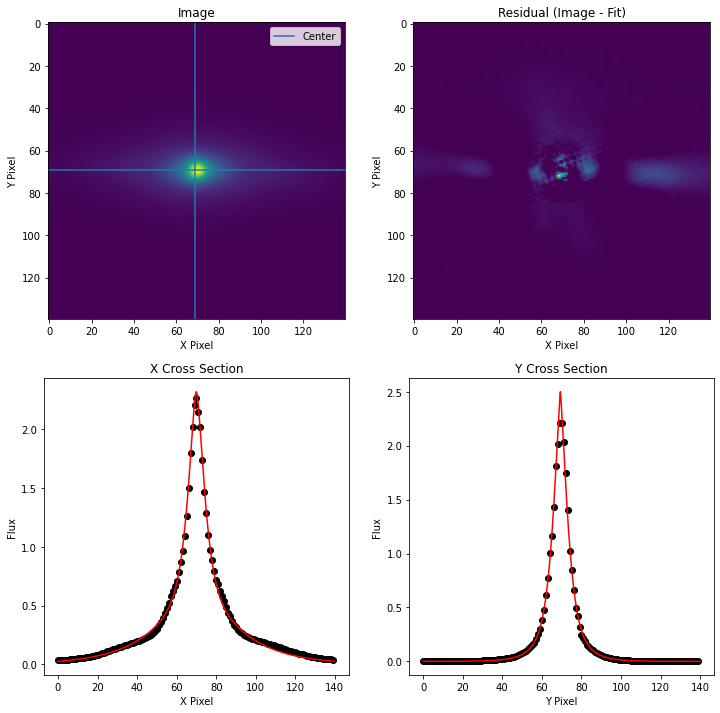

('amplitude_0', 0.5080466335036805)
('r_eff_0', 5.726420017644288)
('n_0', 0.7298263601469193)
('x_0_0', 69.90796992530397)
('y_0_0', 69.31119487859532)
('ellip_0', 0.08415704839483062)
('theta_0', 0.0)
('amplitude_1', 0.17412443920798026)
('r_eff_1', 32.850580415688796)
('n_1', 0.9919894407395188)
('x_0_1', 69.90796992530397)
('y_0_1', 69.31119487859532)
('ellip_1', 0.6340772453163273)
('theta_1', 0.019448013204980085)



9 104


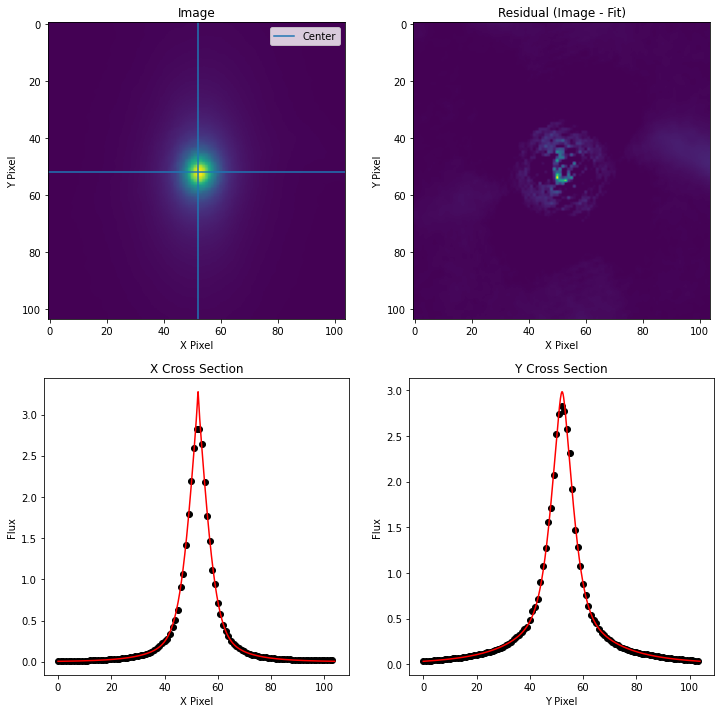

('amplitude_0', 0.6862915962074072)
('r_eff_0', 5.187854637302313)
('n_0', 0.6070386527607325)
('x_0_0', 52.56896664405051)
('y_0_0', 52.104230710844355)
('ellip_0', 0.0)
('theta_0', 0.0)
('amplitude_1', 0.14348176172773602)
('r_eff_1', 27.5548476233309)
('n_1', 1.388237399039056)
('x_0_1', 52.56896664405051)
('y_0_1', 52.104230710844355)
('ellip_1', 0.4251972078708881)
('theta_1', -1.522259274826366)



10 162


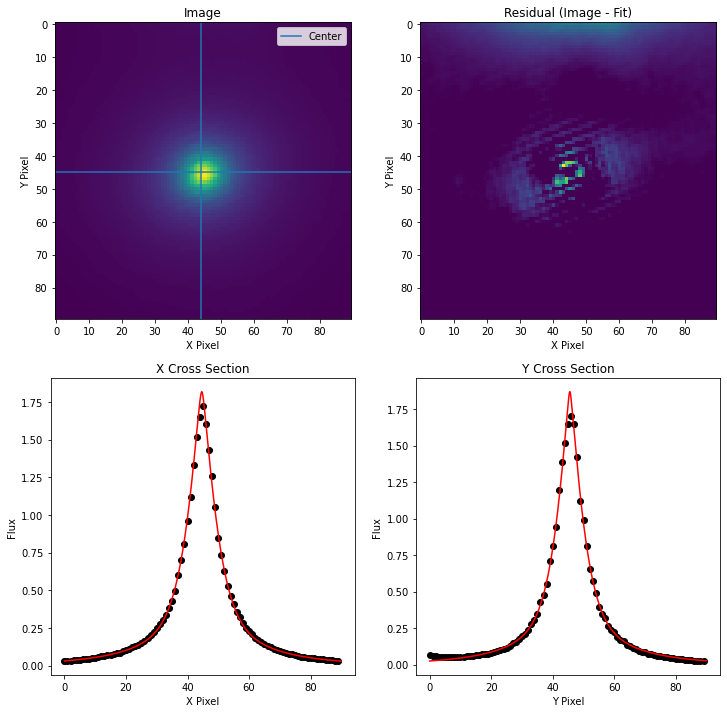

('amplitude_0', 0.33502325230863617)
('r_eff_0', 6.456835086683671)
('n_0', 0.7389524251002302)
('x_0_0', 44.60474456949496)
('y_0_0', 45.56330413690639)
('ellip_0', 0.06730161947972037)
('theta_0', 0.0)
('amplitude_1', 0.08064696466793492)
('r_eff_1', 28.482980090322375)
('n_1', 1.3826850355261717)
('x_0_1', 44.60474456949496)
('y_0_1', 45.56330413690639)
('ellip_1', 0.08102464256568376)
('theta_1', -0.44642587405971973)



11 94


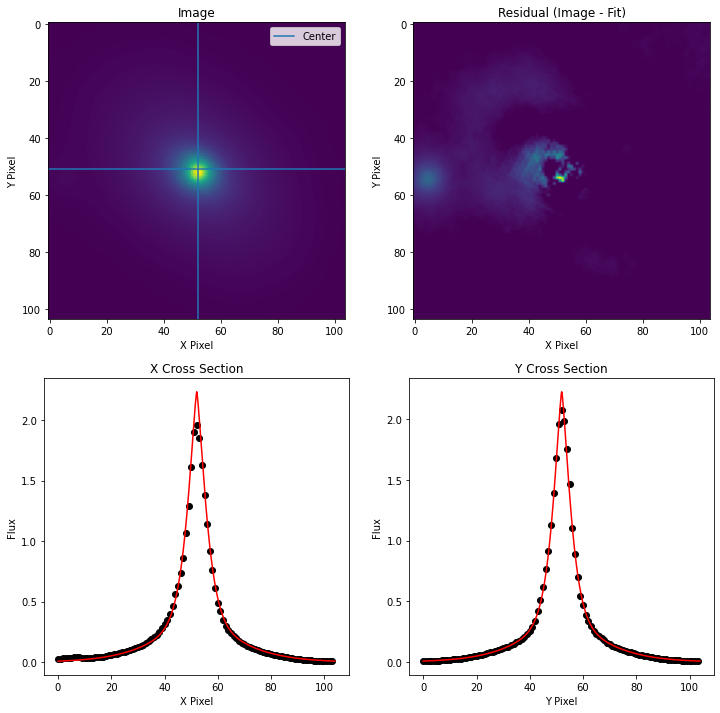

('amplitude_0', 0.5542034895475804)
('r_eff_0', 5.38591443227159)
('n_0', 0.7545138321244028)
('x_0_0', 52.08437104986925)
('y_0_0', 51.996610916735285)
('ellip_0', 0.08989501561186221)
('theta_0', 0.5106299842582327)
('amplitude_1', 0.1181319631279785)
('r_eff_1', 26.366380551194183)
('n_1', 0.7822261881212487)
('x_0_1', 52.08437104986925)
('y_0_1', 51.996610916735285)
('ellip_1', 0.2971335323606903)
('theta_1', 0.7403616975787553)



12 136


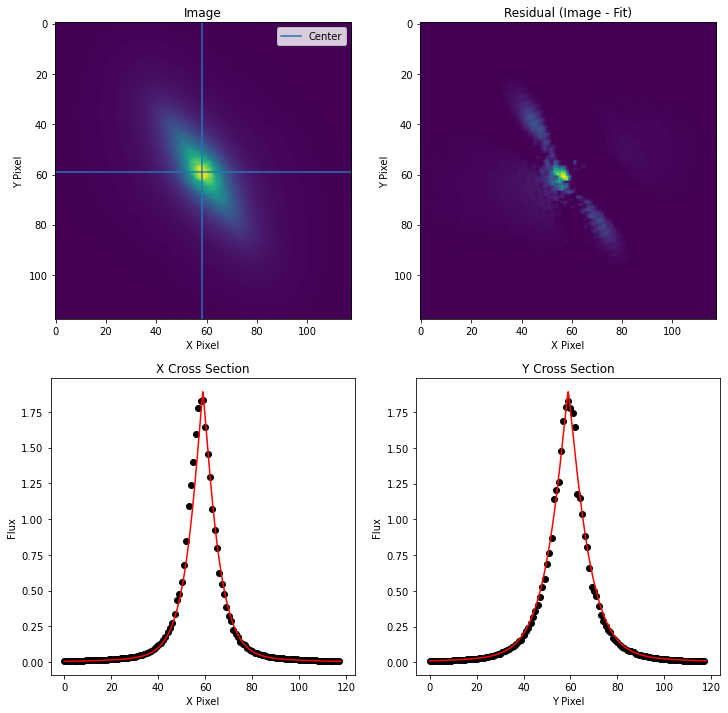

('amplitude_0', 0.4496226545199957)
('r_eff_0', 17.892835673357336)
('n_0', 0.8386915281124229)
('x_0_0', 58.987848996009916)
('y_0_0', 59.013879403652986)
('ellip_0', 0.5728654365164104)
('theta_0', 0.9749316547563829)
('amplitude_1', 0.01944115513129528)
('r_eff_1', 64.77639934179476)
('n_1', 1.1661148230616212)
('x_0_1', 58.987848996009916)
('y_0_1', 59.013879403652986)
('ellip_1', 0.5620270603946514)
('theta_1', 0.9822853672786099)



13 31


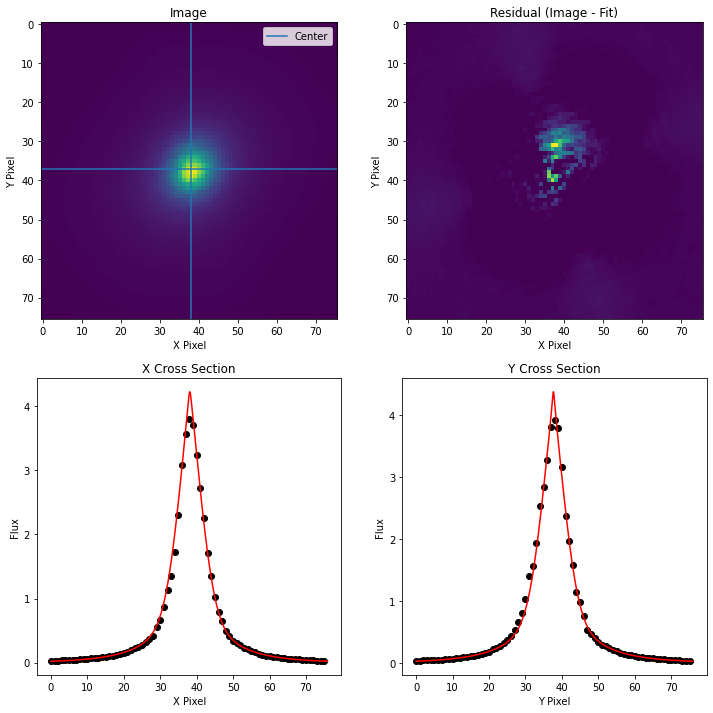

('amplitude_0', 0.9376043292854798)
('r_eff_0', 4.431549038293684)
('n_0', 0.5235155021176959)
('x_0_0', 38.18513328911822)
('y_0_0', 37.630623288916524)
('ellip_0', 0.0)
('theta_0', 0.0)
('amplitude_1', 0.22519716311782603)
('r_eff_1', 17.524104743273647)
('n_1', 1.40211755006321)
('x_0_1', 38.18513328911822)
('y_0_1', 37.630623288916524)
('ellip_1', 0.19574348286790788)
('theta_1', -0.9056887226894895)



Done


In [218]:
###############
# Photometry #
##############

# Load progress bar
pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(order),
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
)

display(pb)

# Copy image for output
image_copy = image.copy()
image_residual_copy = image_residual.copy()
image_zero = np.zeros_like(image_copy) + mean_noise

for i, cat_index in enumerate(order):
    print(i, cat_index)
    
    # Manual rejection list 
    if cat_index in []:
        continue
        
    # Update progress bar 
    pb.value = i + 1
    pb.description = "{}/{}".format(pb.value, len(order))
    
    # Load object and aperture 
    obj = cat[cat_index]
    
    # Estimate center of bobject
    cut = obj.segment.make_cutout(image, masked_array=True)
    cy, cx = np.unravel_index(cut.argmax(), cut.shape)
    
    x = obj.segment.bbox.ixmin + cx
    y = obj.segment.bbox.iymin + cy
    
    # Estimate other parts
    theta=obj.orientation.to(u.rad).value
    ellip=(1-obj.semiminor_axis_sigma.value/obj.semimajor_axis_sigma.value)
    amp = cut.data.max() 
    
    # Define fitting radius 
    r_inner = int(np.round(obj.semimajor_axis_sigma.value)) # inner cutout radius 
    
    # Full target cutout size
    if i < 3:
        r_outter = r_inner * 7
    else:
        r_outter = r_inner * 7
        
    
    # Make images to fit 
    target_zoom = cutout(image_copy, x, y, r_inner)
    target = cutout(image_copy, x, y, r_outter)
    target_residual = cutout(image_residual_copy, x, y, r_outter)
    
    # Fit inner core
    # --------------
    
    # Find center of zoomed cutout image 
    y_0, x_0 = np.array(target_zoom.shape) // 2
    
    # Make inner model
    xy_slack = 10 # x and y value range / 2
    
    model_1 = models.Sersic2D(
                amplitude=amp,
                n=2,
                r_eff=r_inner,
                ellip=ellip,
                theta=theta,
                x_0 = x_0,
                y_0 = y_0,
                #fixed={'theta':True, 'ellip':True},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0, None),
                     'n':(0, 6),
                    'ellip':(0, 1),
                    'theta':(0, 2*np.pi),
                    'x_0': (x_0-xy_slack, x_0+xy_slack),
                    'y_0': (y_0-xy_slack, y_0+xy_slack),
                })
    
    
    # Fit core model to zoomed cutout to tighten first guess
    model_1, fit = fit_model(target_zoom, model_1, maxiter=10000, epsilon=1e-40)
    
    # Fix the center x and y of all models to match the fitted guess 
    """
    for pn in model.param_names:
        model.fixed[pn] = True            
    """
    
    model_1.fixed.update({
        'x_0': True,
        'y_0': True,
    })
    
    del model_1.bounds['x_0']
    del model_1.bounds['y_0']
    
    
    # Fit glow around target
    # ----------------------
    
    # Remove old center and add new center
    y_0, x_0 = np.array(target_zoom.shape) // 2
    
    model_1.x_0 -= x_0
    model_1.y_0 -= y_0

    y_0, x_0 = np.array(target.shape) // 2

    model_1.x_0 += x_0
    model_1.y_0 += y_0
    
    # Setup second model for fitting
    xy_slack = 5
    
    model_2 = models.Sersic2D(
                amplitude=0,
                n=0.1,
                r_eff=model_1.r_eff*3,
                ellip=ellip,
                theta=theta,
                x_0 = model_1.x_0,
                y_0 = model_1.y_0,
                fixed={'x_0': True, 'y_0': True, 'theta':True, 'ellip':True},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0, None),
                    'n':(0, 2),
                    'ellip':(0, 1),
                    'theta':(0, 2*np.pi),
                })
    
    # Fit second model to the residual of the image (image with segmented area masked)
    model_2, fits = fit_model(target_residual, model_2, maxiter=10000, epsilon=1e-40)
    
    
    # PSF Models
    # ----------
    
    # Setup PSF image and fit it to image of target to estimate param guess
    if i < -1:
        # Brightest sources
        model_3 = Moffat2D(
            amplitude=amp,
            x_0=model_1.x_0,
            y_0=model_1.y_0,
            #ellip=(1-aperture.b/aperture.a),
            #theta=aperture.theta,
            fixed={'x_0': True, 'y_0': True,},
            bounds={
                    'amplitude':(0, None),
                    #'ellip':(0, 1), 'theta':(0, np.pi*2),
                    #'x_0': (x_0-xy_slack, x_0+xy_slack),
                    #'y_0': (y_0-xy_slack, y_0+xy_slack),
                }
        )
    else:
        # Normal sources
        model_3 = models.Gaussian2D(
            amplitude=amp,
            x_mean=model_1.x_0,
            y_mean=model_1.y_0,
            x_stddev=model_1.r_eff,
            y_stddev=model_1.r_eff,
            fixed={'x_mean': True, 'y_mean': True,}
        )
        
                
    model_3, fits = fit_model(target, model_3, maxiter=10000, epsilon=1e-40)
    
    # Final Fit
    # ---------
    
    # Combine models
    model = model_1 + model_2# + model_3
    
    # Fit combined model
    model, fit = fit_model(target, model, maxiter=10000, epsilon=1e-40)
    model, fit = fit_model(target, model, maxiter=10000, epsilon=1e-40)
    
    # Make center of model the center of model_1 
    model.x_0 = model_1.x_0
    model.y_0 = model_1.y_0
    
    # Plot and Print
    # --------------
    
    fig, ax = plot_fit(target, model) #, vmin=vmin, vmax=vmax)
    plt.show()
    
    print("\n".join([str(j) for j in zip(model.param_names, model.parameters)]) + "\n"*3)
    
    # Subtract from image
    # -------------------
    
    if fit.fit_info['ierr'] > 4:
        # Fit failed
        continue
    
    # Make new image
    size = r_inner * 20 
    y_arange, x_arange = np.mgrid[
        int(model.y_0.value)-size:int(model.y_0.value)+size,
        int(model.x_0.value)-size:int(model.x_0.value)+size, ]
    model_image = model(x_arange, y_arange)
    
    # Subtract cutout from main copy image
    image_copy = model_subtract(image_copy, np.array(model_image), x, y)
    image_copy[y-8:y+8, x-8:x+8] = np.nan 
    image_copy = np.clip(image_copy, 0, image_copy.max())
    
    # Add cutout to main cutout only image 
    image_zero = model_subtract(image_zero, -1*np.array(model_image), x, y)
    
    # Subtract cutout second component from residual image 
    image_residual_copy = model_subtract(image_residual_copy, np.array(model_image), x, y)
    
print("Done")


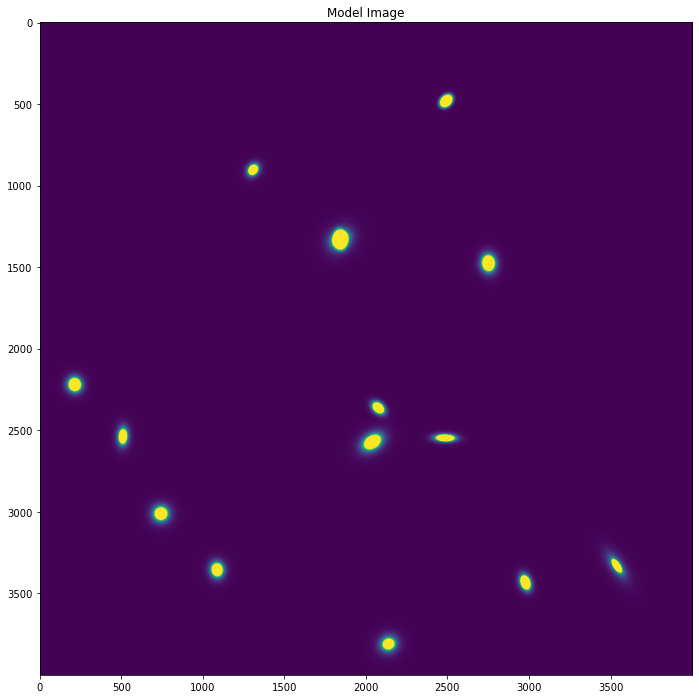

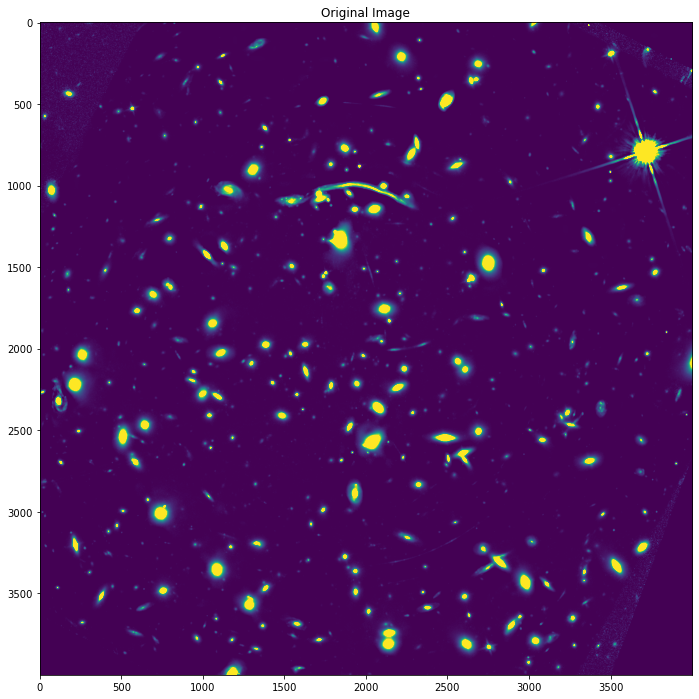

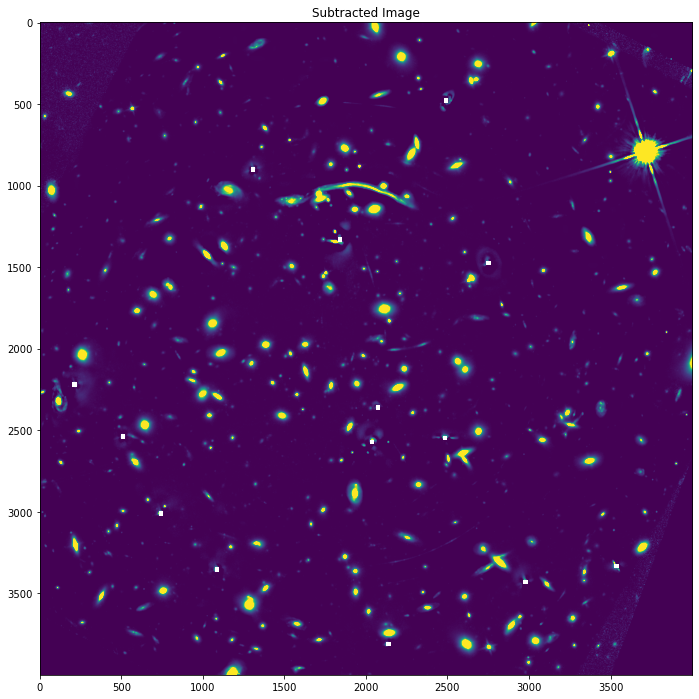

In [219]:
vmin = 0
vmax = mean_noise*200

plt.imshow(image_zero, vmin=vmin, vmax=vmax)
plt.title("Model Image")
plt.show()

plt.imshow(image, vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.show()

plt.imshow(image_copy, vmin=vmin, vmax=vmax)
plt.title("Subtracted Image")
plt.show()

# Convolve Subtracted Image

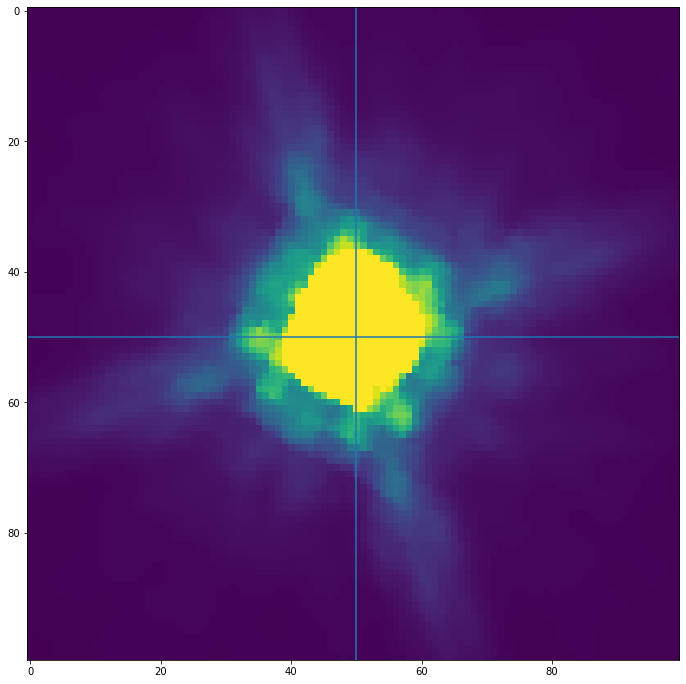

Image Max: 1447.604736328125
Amplitude: 1320.892411902444
Center: (48.91118038868664, 49.62014107453632)
Sigma = (3.5843792317019028, 3.0819133864347483)
Mean FWHM: 8 Pix 
FWHM: (x=8.440568063804275, y=7.25735141942576) Pix 


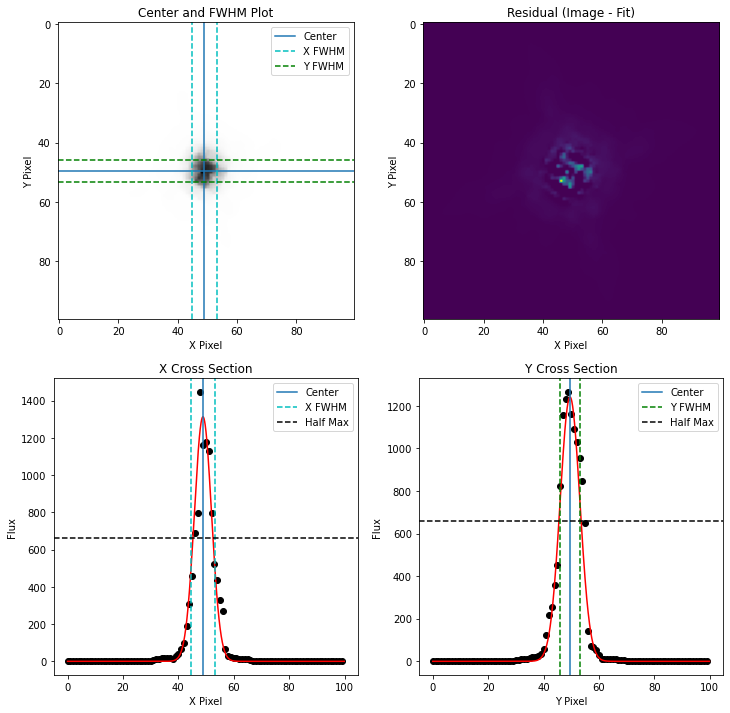

7.848959741615017


In [220]:
# Convolve with PSF sized gaussian.
# First fit gaussian to bright star PSF 

PSF = cutout(data, 5671, 6789, 100, vmin=0)

plt.imshow(PSF, vmin=0, vmax=20)
plt.axhline(PSF.shape[0]//2)
plt.axvline(PSF.shape[0]//2)
plt.show()

star_fwhm = measure_fwhm(PSF).mean()
print(star_fwhm)

In [221]:
kernel = Gaussian2DKernel(x_stddev=3.5, 
                          x_size=31, y_size=31)
kernel.normalize()

image_smoothed = convolve(image_copy, kernel)

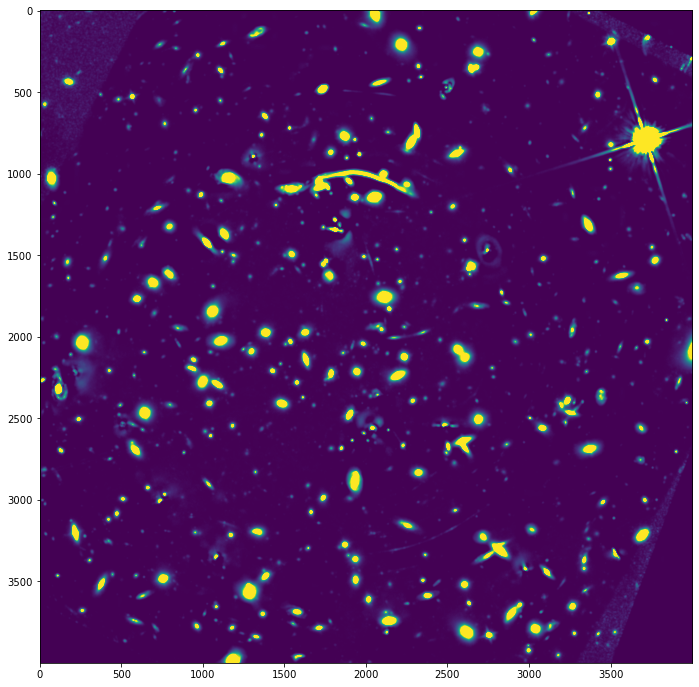

In [222]:
plt.imshow(image_smoothed, vmax=mean_noise*100)

# Do AP on subtracted image 

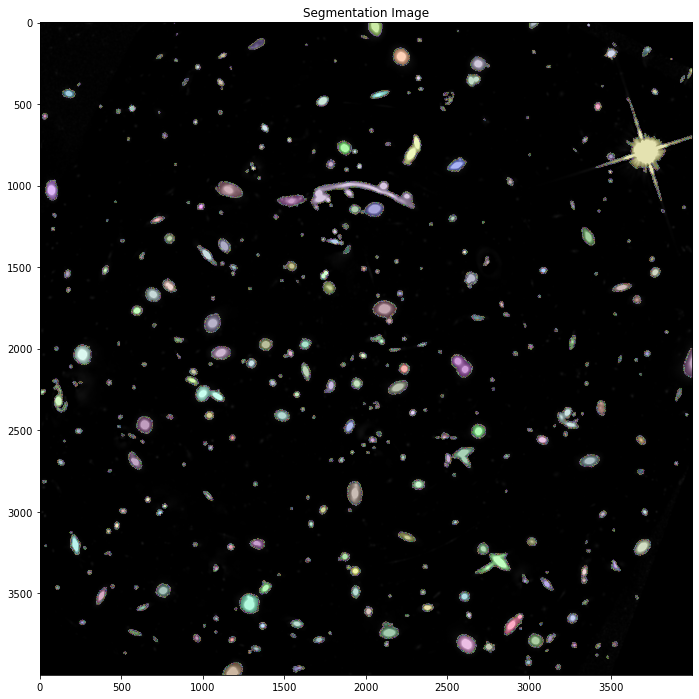

In [223]:
nsigma_smoothed = np.zeros_like(image_smoothed) + image_smoothed.mean()
segm_smoothed = make_segments(image_smoothed, nsigma=nsigma_smoothed, kernel_size=None)
plot_segments(segm_smoothed, image_smoothed, vmin=0, vmax=mean_noise*200)

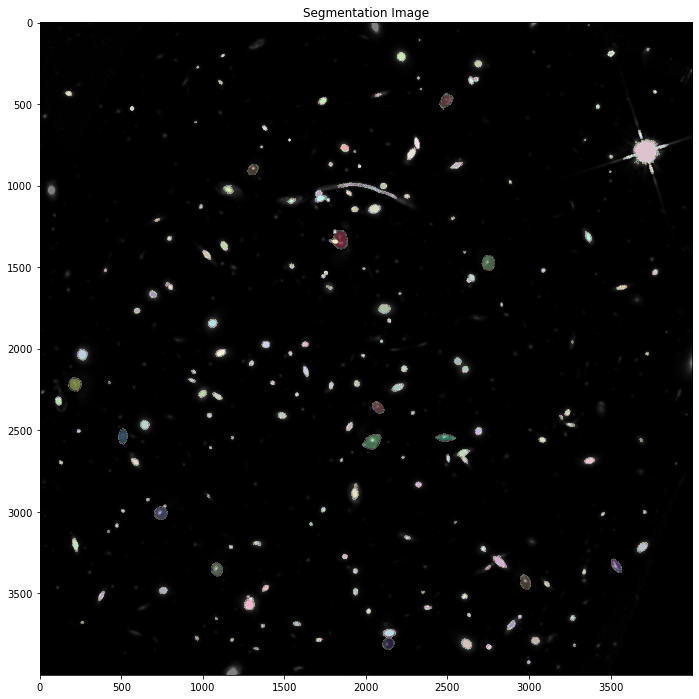

In [224]:
segm_deblend_smoothed = deblend_segments(image_smoothed, segm_smoothed)
plot_segments(segm_deblend, image_smoothed, vmin=0, vmax=mean_noise*300)

In [225]:
segm_deblend_smoothed.remove_border_labels(50)
print(len(segm_deblend_smoothed.segments))
cat = source_properties(image_smoothed, segm_deblend_smoothed, wcs=wcs)

418


## Multi Aperture Photometry

In [433]:
def flux_to_abmag(flux):
    pass

In [484]:
radii = [2**n for n in range(1, 5)]

n = 12
max_pix = 60
radii = [x * int(max_pix/n) for x in range(1, n+1)]

#radii.append(25)
radii.sort()

annulus_min = radii[-1] 
annulus_max = radii[-1] * 2 

radii, annulus_min, annulus_max

([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 60, 120)

In [485]:
positions = []
apertures = []
for obj in cat:
    # cut = obj.segment.make_cutout(image, masked_array=True)
    cut_size = 10
    cut = cutout(image_smoothed, 
                    int(np.round(obj.xcentroid.value)), 
                    int(np.round(obj.ycentroid.value)),
                    cut_size)
    
    cy, cx = np.unravel_index(cut.argmax(), cut.shape)
    
    x = int(np.round(obj.xcentroid.value)) + cx - cut_size//2
    y = int(np.round(obj.ycentroid.value)) + cy - cut_size//2
    
    position = np.transpose((x, y))
    positions.append(tuple(position))

apertures = [CircularAperture(positions, r=r) for r in radii]
apertures.append(CircularAnnulus(positions, r_in=annulus_min, r_out=annulus_max))

annulus_aperture = apertures[-1]
annulus_area = annulus_aperture.area

In [486]:
# plot_apertures(image_smoothed, apertures, vmin=0, vmax=mean_noise*100, color='r')

In [493]:
phot_table = aperture_photometry(image_smoothed, apertures)

In [494]:
annulus_masks = annulus_aperture.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(image_smoothed)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

phot_table['annulus_median'] = bkg_median

for i, aperture in enumerate(apertures[:-1]):
    phot_table["aperture_bkg_{}".format(i)] = bkg_median * aperture.area
    bkgsub = phot_table["aperture_sum_{}".format(i)] - phot_table["aperture_bkg_{}".format(i)]
    phot_table["aperture_sum_{}_bkgsub".format(i)] = bkgsub
    
#phot_table.sort("aperture_sum_1_bkgsub", reverse=True)
#phot_table

In [495]:
# annulus_bkg_mean = phot_table.columns[-1] / annulus_area
# for i, aperture in enumerate(apertures[:-1]):
#     bkgsub = phot_table["aperture_sum_{}".format(i)] - (annulus_bkg_mean * aperture.area)
#     phot_table["aperture_sum_{}_bkgsub".format(i)] = np.clip(bkgsub, 0, np.inf)
    
# #phot_table.sort("aperture_sum_1_bkgsub")
# phot_table

In [496]:
def slider(x):
    cutout_size = radii[-1]*4
    
    
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    target_bkg = phot_table[x][phot_table.colnames[-1]]/annulus_area
    
    
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(target, vmin=vmin, vmax=vmax)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(np.clip(target-target_bkg, 0, target.max()), vmin=vmin, vmax=vmax)
    ax[0,1].set_title("Target [CircularAnnulus Subtracted]")
    
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    for r in radii:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,1], color='r')
    
    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, label="Raw")
    
    y_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, linestyle='--', label="Bkg Subtracted")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Size [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, label="Raw") 
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, linestyle='--', label="Bkg Subtracted") 
    
    ax[1,1].set_title("Photometic Density")
    ax[1,1].set_xlabel("Aperture Size [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    cutout_size = radii[-1] * 2
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    plt.imshow(target)
    for r in radii:
        CircularAperture(position, r=r).plot(plt.gca(), color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(plt.gca(), color='r')


    plt.show()

vmin = 0
vmax = mean_noise*0.5
#widgets.interact_manual(slider, x=widgets.IntSlider(min=0, max=len(phot_table)-1));
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=417), Output()), _dom_classes=('widget-inte…

In [382]:
len([(phot_table["aperture_sum_{}".format(i)]) for i in range(len(radii))])

10

## Single Aperture Photometry

In [44]:
r = 25.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    ellip = obj.semiminor_axis_sigma.value / obj.semimajor_axis_sigma.value 
    a = r 
    b = (1 - ellip)*r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

In [148]:
r = 25.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    theta = obj.orientation.to(u.rad).value
    apertures.append(CircularAperture(position, r=r))

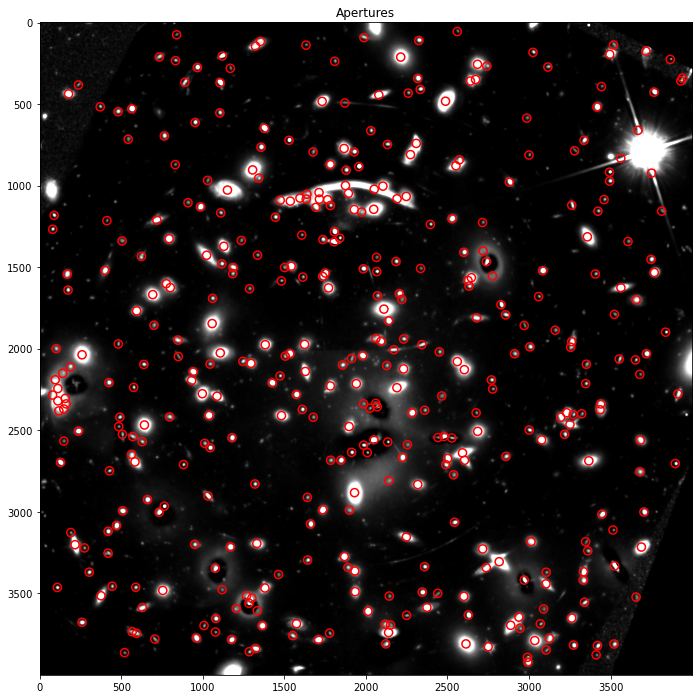

In [149]:
plot_apertures(image_smoothed, apertures, vmin=0, vmax=mean_noise*100, color='r')

In [150]:
aperture_photometry_results = []
for aperture in apertures:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])

# Save to Table

In [47]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)
table.sort('aperture_sum', reverse=True)

In [48]:
table

<QTable length=441>
  id      xcentroid      ...         gini            aperture_sum   
             pix         ...                                        
int64      float64       ...       float64             float64      
----- ------------------ ... -------------------- ------------------
  105 1807.7498235594676 ...   0.5497458380100056 1323.5194369840003
  193 215.91330051850713 ...  0.10021636159097286 1060.9098782457343
  374 2739.6328027993445 ...   0.2946231860194561 1046.7286728760037
  287 2970.6061679474433 ...  0.35186751617249457 1034.1402286583777
  281 3524.4521162740302 ...   0.3489765573676772  910.1470100448505
   67 1303.5072499693838 ...    0.401673508046884  815.0026879999289
  429  2048.225420702691 ...   0.2949773568782795  787.4974605396835
  219  505.8921534078758 ...  0.05412191310175176  705.7163428952223
  218 2478.4111322648223 ...  0.30869073328279084  703.1967410323974
  ...                ... ...                  ...                ...
  226   147.688995500672 ...  0.04591801714815769 1.8843022880676012
  276 274.00439361198625 ...  0.11994569423921818 1.5903360121157173
  125 1613.1139399781598 ...  0.15844373124041372 1.5628695677026698
   49  2985.979430388065 ... 0.055844891267630085 1.4014759335784028
  107 3606.9611588851994 ...  0.08084670351359115  1.230048164931706
  133 2070.9308642615665 ...   0.1622402197750686  1.054364474328946
  228 1011.2232320587624 ...  0.13996567605283136 0.8525142153722411
  130 1286.4514672680414 ...   0.0968710661032836 0.7861145410053829
  150 3160.3338682140966 ...  0.09221504278941556 0.5063779392897749
  118 2335.1887258650854 ...  0.05748570830660313 0.4700334342018775

In [49]:
table.write(output_path, format="ascii.csv", overwrite=True)

# Compare Processed Image vs Raw Data 

In [51]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image_copy, aperture)['aperture_sum'][0])
    
a2 = np.array(aperture_photometry_results)

In [52]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])
    
a1 = np.array(aperture_photometry_results)

In [53]:
np.round(100*(a1-a2)/a1, 2).astype(int)

array([                   0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                   89,
                          0, -9223372036854775808, -9223372036854775808,
                          0,                    0,                    0,
                          0,                   92,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                   15,                    0,
                          0,                    0,                    2,
                          0,                    0,                    0,
       -9223372036854775808,                    0, 

In [54]:
xh, yh = np.histogram(np.round(100*(a1-a2)/a1))
plt.bar(yh[:-1], xh)

ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
a1[1], a2[1]

# Save Catalog

In [ ]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)

In [ ]:
table.write(output_path, format="ascii.csv", overwrite=True)

In [ ]:
3, 50, log space 

In [165]:
>>> from astropy.stats import SigmaClip
>>> from photutils import Background2D, MedianBackground
>>> sigma_clip = SigmaClip(sigma=3.)
>>> bkg_estimator = MedianBackground()
>>> bkg = Background2D(image, (50, 50), filter_size=(3, 3),
...                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

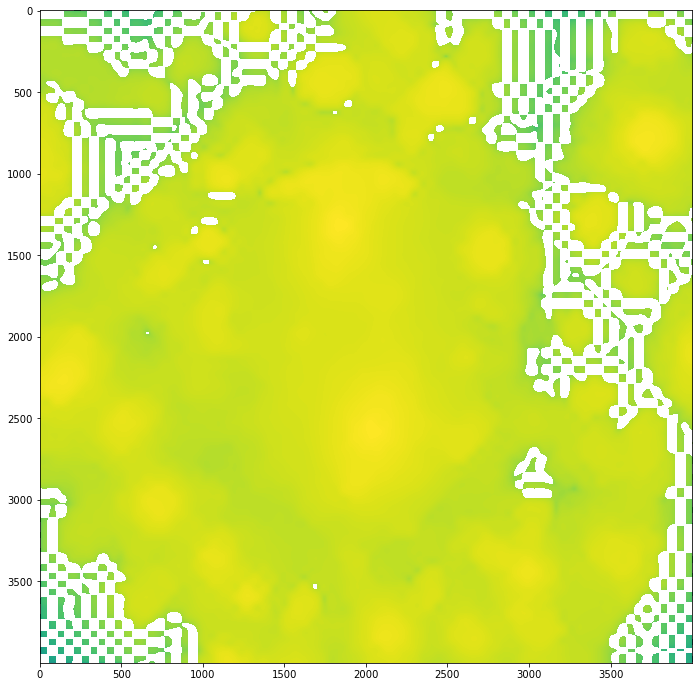

In [179]:
plt.imshow(np.log(bkg.background))

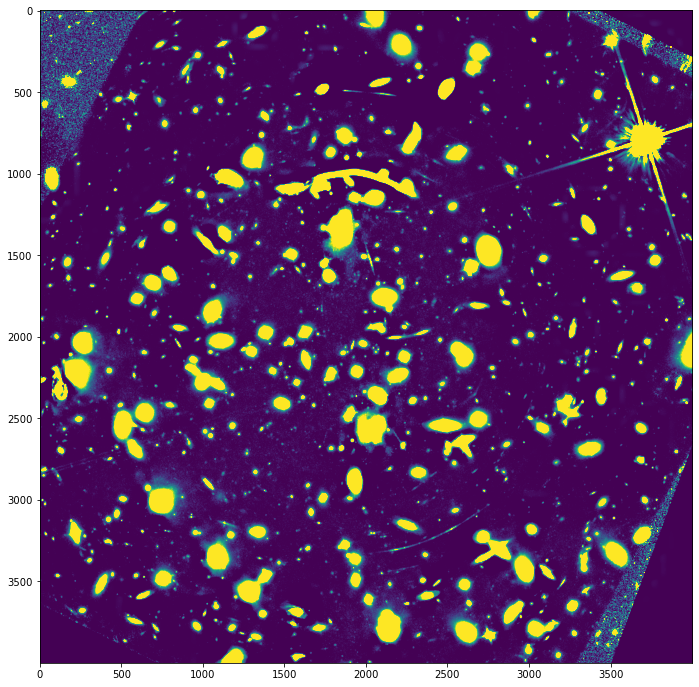

In [180]:
plt.imshow(np.clip(image-bkg.background,0, 1e20), vmin=0, vmax=mean_noise*20)

In [172]:
bkg_sub = image-bkg.data

In [173]:
bkg_sub.mean()

0.0

In [175]:
image.mean()

0.012618022

In [176]:
bkg.data.mean()

0.012618022

In [177]:
np.allclose(image, bkg.data)

True

In [181]:
image = image-bkg.background